<a href="https://colab.research.google.com/github/ubclaunchpad/tl-dr/blob/optimization/summary_be/ml_notebook/fastBART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fastBART
Adaptation of [fastT5](https://github.com/Ki6an/fastT5) for BART text summarization.

*   BART is converted to ONNX format and quantized
*   Model is "flattened" into a directed graph with nodes being operators
*   Quantization truncates floating point model weights to 8-bit integers
*   We should expect a significant decrease in model size and inference time

**Work in progress**
*   The ONNX model does not have the same outputs as the PyTorch model -> bug
*   ONNX did not increase inference speed as much as expected -> possibly related to bug above
*   CoLab keeps crashing during quantization

## Transformers architecture
![picture](https://drive.google.com/uc?export=view?&id=1pEr3mTnWSdLAzCfnDYC0G3lg2jZPZiBU)

### Decoder inefficiencies

*   Note in **Figure 1** that the encoder output is fed as the input to the decoder. This output is called a hidden state, and the same hidden state is used for each subsequent computation in the decoder.
* The encoder output can be computed once, saved, and reused for each subsequent step.
*   The generic Transformers class in PyTorch does not automatically save the encoder output, so the encoder recomputes hidden states during each decoder timestep.


### Token embedding inefficiencies


*   **Figure 2** illustrates how the embedding of a decoded token depends only on the previous token decoded before it.
*   Caching can be applied to prevent unnecessary computation, shown in **Figure 3**.
*   Seperating the encoder and decoder allows us to control the input/output, ensuring cached values are being passed and only computations related to updating the last token are computed.

<img src="https://drive.google.com/uc?export=view?&id=1ipBdNpiZjG5eMECgcNNTOW1u4VBLjVzO" alt="drawing" width="550"/>

### HuggingFace optimizations
Understanding these optimization strategies is important, because HuggingFace applies them to our PyTorch BART model. We need to ensure that these optimizations are carried over correctly to the ONNX model!

In [ ]:
!pip install -q torch==1.12.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q -U transformers==4.4.2 onnx==1.8.1 onnxruntime==1.6.0
import torch

## Creating classes to specify input and ouput of the ONNX model

Caching is used to speed up generation during decoding:


*   BART has an auto-regressive decoder, which means that future generation steps depend on the same output token hidden state. We will avoid recomputation of the hidden state by saving it.
* ```past_key_values``` is returned when ```use_cache``` is True, and contains pre-computed hidden states to speed up decoding.

**Problem**: ```past_key_values``` is a tuple, and must be flattened in the ONNX model. However, the decoder of ```BartForConditionalGeneration``` expects a tuple input.

**Solution**: ```past_key_values``` is represented as a list, and ```DecoderWithLMhead``` will create a tuple from the flattened ```past_key_values``` input. The tuple is then passed to the decoder as normal.


In [ ]:
class BartEncoder(torch.nn.Module):
    """ Creation of a class to output only the last hidden state from the encoder """
    # The last hidden state is the sequence of hidden states at the output of the last layer,
    # which is fed as the input to the decoder. In other words, it's the only one we care about.

    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, *input, **kwargs):
        return self.encoder(*input, **kwargs)[0]

class DecoderWithLMhead(torch.nn.Module):
    """ Creation of a class to combine the decoder and the lm head """
    # lm_head specifies what the model will be doing. In this case, we want our model to do language
    # modelling, so we combine the decoder with a Language Modelling head.

    def __init__(self, decoder, lm_head, final_logits_bias, config):
        super().__init__()
        self.decoder = decoder
        self.lm_head = lm_head
        # BART uses final_logits_bias unlike T5
        self.final_logits_bias = final_logits_bias
        self.config = config

    def forward(self, *inputs):

        input_ids, attention_mask, encoder_hidden_states = inputs[:3]
        # Creating a tuple for past_key_values from flattened list
        list_pkv = inputs[3:]
        past_key_values = tuple(list_pkv[i : i + 4] for i in range(0, len(list_pkv), 4))

        decoder_output = self.decoder(
            input_ids=input_ids,  # decoder_input_ids
            encoder_attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            past_key_values=past_key_values,
        )

        lm_head_out = self.lm_head(decoder_output[0]) + self.final_logits_bias

        return lm_head_out, decoder_output[1]

### Initial decoder

The very first time that the decoder receives an input from the encoder (per decoding step), there is no need to use caching. This input is called the "initial hidden state". Subsequent recurrent decoding steps rely on the same input hidden states, and hence will use ```DecoderWithLMHead```.

In [ ]:
class DecoderWithLMheadInitial(torch.nn.Module):
    """ Creation of a class to combine the decoder and the lm head """

    def __init__(self, decoder, lm_head, final_logits_bias, config):
        super().__init__()
        self.decoder = decoder
        self.lm_head = lm_head
        self.final_logits_bias = final_logits_bias
        self.config = config

    def forward(self, input_ids, attention_mask, encoder_hidden_states):
        decoder_output = self.decoder(
            input_ids=input_ids,
            encoder_attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
        )

        return (
            self.lm_head(decoder_output[0]) + self.final_logits_bias,
            decoder_output[1],
        )

## Converting Model to ONNX

Since BART is an encoder-decoder seq2seq model, the encoder and decoder have to be split and converted seperately. Specifically, the encoder, initial decoder, and decoder are converted into three seperate ONNX models.

In [ ]:
from transformers import (
    AutoConfig,
    AutoTokenizer,
    BartTokenizerFast,
    BartForConditionalGeneration,
)
import functools
import operator
from pathlib import Path
import os

In [ ]:
MODEL_PATH = 'facebook/bart-large-cnn'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = BartForConditionalGeneration.from_pretrained(MODEL_PATH, use_cache=True)

In [ ]:
_folder = Path.cwd()
saved_models_path = _folder.joinpath("models")
saved_models_path

PosixPath('/content/models')

In [ ]:
import functools
import operator
from pathlib import Path
import os

In [ ]:
def get_model_paths(pretrained_model, model_path, quantized):

    model_path.mkdir(parents=True, exist_ok=True)

    # gets only the filename
    pretrained_model_name = Path(pretrained_model).stem

    if not quantized:
        encoder_path = model_path / pretrained_model_name / "encoder" / "model.onnx"
        decoder_path = model_path / pretrained_model_name / "decoder" / "model.onnx"
        init_decoder_path = model_path / pretrained_model_name / "init-decoder" / "model.onnx"
    else:
        encoder_path = model_path / pretrained_model_name / "encoder-quantized" / "model.onnx"
        decoder_path = model_path / pretrained_model_name / "decoder-quantized" / "model.onnx"
        init_decoder_path = model_path / pretrained_model_name / "init-decoder-quantized" / "model.onnx"

    encoder_path.parent.mkdir(parents=True, exist_ok=True)
    decoder_path.parent.mkdir(parents=True, exist_ok=True)
    init_decoder_path.parent.mkdir(parents=True, exist_ok=True)
        
    return encoder_path, decoder_path, init_decoder_path

In [ ]:
def turn_model_into_encoder_decoder(model):
    """Generates an encoder and a decoder model with a language model head from a pretrained BART model
    Args:
        pretrained_version (str): Name of a pretrained model, or path to a pretrained / finetuned version of BART
    Returns:
        simplified_encoder: pytorch BART encoder with a wrapper to output only the hidden states
        decoder_with_lm_head: pytorch BART decoder with a language modelling head
        decoder_with_lm_head_init: initial pytorch BART decoder with a language modelling head
    """
    encoder = model.get_encoder()
    decoder = model.get_decoder()
    lm_head = model.get_output_embeddings()
    final_logits_bias = model.final_logits_bias

    simplified_encoder = BartEncoder(encoder)
    decoder_with_lm_head = DecoderWithLMhead(decoder, lm_head, final_logits_bias, model.config)
    decoder_with_lm_head_init = DecoderWithLMheadInitial(decoder, lm_head, final_logits_bias, model.config)

    return simplified_encoder, decoder_with_lm_head, decoder_with_lm_head_init

### Generating ONNX representations
Exporting a model in ONNX is done by "tracing" the graph. In other words, it keeps track of operations the PyTorch model uses to process a dummy input. Each operation is then converted to ONNX format.
*    The dummy input here is a CNN news excerpt because it is most similar to what our extension will be processing

*    [ONNX documentation](https://pytorch.org/docs/stable/onnx.html#functions)

In [ ]:
TEXT = """Elon Musk sold $3.95 billion worth of Tesla stock since completing his purchase of Twitter late last month. 
          Musk’s Tesla stock sales, totaling 19.5 million shares, have been widely anticipated ever since the Tesla CEO
          reached a deal to buy Twitter for $44 billion. Musk had sold blocks of Tesla shares worth a total of $15.4 billion
          earlier this year since his deal to buy Twitter was announced. Twitter confirmed Musk bought the social media company
          October 27, but he waited until November 4 to start selling additional Tesla shares. He also sold blocks of Tesla 
          stock on Monday and Tuesday this week, according to filings to the Securities and Exchange Commission late Tuesday night. 
          It’s not clear if the money Musk raised went toward the Twitter purchase, or to support losses at Twitter since he 
          took over. Musk disclosed last week that Twitter has seen a “massive drop in revenue,” as a growing number of advertisers 
          pause spending on the platform in the wake of his takeover of the company. He blamed “activist groups” pressuring 
          advertisers for the loss of ad dollars."""

In [ ]:
def generate_onnx_representation(model):
    """Exports a given BART model to onnx"""
    (
        simplified_encoder,
        decoder_with_lm_head,
        decoder_with_lm_head_init,
    ) = turn_model_into_encoder_decoder(model)

    model_config = model.config
    
    encoder_path, decoder_path, init_decoder_path = get_model_paths(
        model_config._name_or_path, saved_models_path, quantized=False
    )

    # creating dummy inputs
    tokenizer = AutoTokenizer.from_pretrained(model_config._name_or_path)
    sample_input = TEXT
    model_inputs = tokenizer(sample_input, return_tensors="pt")
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    
    batch_size = 1
    n_heads = model_config.decoder_attention_heads
    seq_length_a, seq_length_b = input_ids.shape
    d_kv = model_config.d_model // n_heads

    input_ids_dec = torch.ones((batch_size, 1), dtype=torch.int64)
    attention_mask_dec = torch.ones((batch_size, seq_length_b), dtype=torch.int64)
    enc_out = torch.ones(
        (batch_size, seq_length_b, model_config.d_model), dtype=torch.float32
    )
    sa = torch.ones(
        (batch_size, n_heads, seq_length_a, d_kv), dtype=torch.float32
    )
    ca = torch.ones(
        (batch_size, n_heads, seq_length_b, d_kv), dtype=torch.float32
    )
    # (self attention keys, self attention values, cross attention keys, cross attention values)
    attention_block = (sa, sa, ca, ca)
    past_key_values = (attention_block,) * model_config.decoder_layers
    flat_past_key_values = functools.reduce(operator.iconcat, past_key_values, [])

    decoder_all_inputs = tuple(
        [input_ids_dec, attention_mask_dec, enc_out] + flat_past_key_values
    )

    # Exports to ONNX
    with torch.no_grad():

        decoder_inputs = [
            "input_ids",
            "encoder_attention_mask",            
            "encoder_hidden_states",            
        ]
        pkv_input_names = ["pkv_{}".format(i) for i in range(len(flat_past_key_values))]
        decoder_input_names = decoder_inputs + pkv_input_names
        decoder_output_names = ["logits", "output_past_key_values"]

        dyn_axis_general = {0: "batch", 1: "sequence"}
        dyn_axis_pkv = {0: "batch", 2: "seq_length"}
       
        dyn_axis = {
            "input_ids": dyn_axis_general,
            "encoder_attention_mask": dyn_axis_general,
            "encoder_hidden_states": dyn_axis_general,
            "logits": dyn_axis_general,
            "output_past_key_values": dyn_axis_general,
        }

        dyn_pkv = {
            "pkv_{}".format(i): dyn_axis_pkv
            for i in range(len(flat_past_key_values))
        }

        dyn_axis_params = {**dyn_axis, **dyn_pkv}


        # export decoder to use past key values
        torch.onnx.export(
            decoder_with_lm_head,
            decoder_all_inputs,
            decoder_path.as_posix(),
            export_params=True,
            do_constant_folding=False,
            opset_version=12,
            input_names=decoder_input_names,
            output_names=decoder_output_names,
            dynamic_axes=dyn_axis_params,
        )
        
        # export initial decoder to produce past key values
        torch.onnx.export(
            decoder_with_lm_head_init,
            (input_ids_dec, attention_mask_dec, enc_out),
            init_decoder_path.as_posix(),
            export_params=True,
            do_constant_folding=False,
            opset_version=12,
            input_names=[
                "input_ids",
                "encoder_attention_mask",
                "encoder_hidden_states",
            ],
            output_names=decoder_output_names,
            dynamic_axes={
                # batch_size, seq_length = input_shape
                "input_ids": dyn_axis_general,
                "encoder_attention_mask": dyn_axis_general,
                "encoder_hidden_states": dyn_axis_general,
                "logits": dyn_axis_general,
                "past_key_values": dyn_axis_general,
            },
        )

        # export encoder
        torch.onnx.export(
            simplified_encoder,
            args=(input_ids, attention_mask),
            f=encoder_path.as_posix(),
            export_params=True,
            opset_version=12,
            do_constant_folding=True,
            input_names=["input_ids", "attention_mask"],
            output_names=["hidden_states"],
            dynamic_axes={
                "input_ids": {0: "batch", 1: "seq_length"},
                "attention_mask": {0: "batch", 1: "seq_length"},
                "hidden_states": {0: "batch", 1: "seq_length"},
            },
        )

    return encoder_path, decoder_path, init_decoder_path

In [ ]:
# MOMENT OF TRUTH!
# Sometimes this will not work. Try re-reunning the cell or refreshing the notebook, restarting your runtime and "Run All".
# Look in the file paths specified below to check they are generated.
onnx_model_paths = generate_onnx_representation(model)
onnx_model_paths

/usr/local/lib/python3.7/dist-packages/transformers/models/bart/modeling_bart.py:856: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1:
/usr/local/lib/python3.7/dist-packages/transformers/models/bart/modeling_bart.py:216: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  src_len,
/usr/local/lib/python3.7/dist-packages/transformers/models/bart/modeling_bart.py:255: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as 

(PosixPath('/content/models/bart-large-cnn/encoder/model.onnx'),
 PosixPath('/content/models/bart-large-cnn/decoder/model.onnx'),
 PosixPath('/content/models/bart-large-cnn/init-decoder/model.onnx'))

In [ ]:
import onnx
#Validating ONNX models, may crash due to RAM restrictions
try:
    onnx.checker.check_model("/content/models/bart-large-cnn/encoder/model.onnx")
except onnx.checker.ValidationError as e:
    print(f"Encoder model is invalid: {e}")
else:
    print("Encoder model is valid!")

try:
    onnx.checker.check_model("/content/models/bart-large-cnn/decoder/model.onnx")
except onnx.checker.ValidationError as e:
    print(f"Decoder model is invalid: {e}")
else:
    print("Decoder model is valid!")

try:
    onnx.checker.check_model("/content/models/bart-large-cnn/init-decoder/model.onnx")
except onnx.checker.ValidationError as e:
    print(f"Initial decoder model is invalid: {e}")
else:
    print("Initial decoder model is valid!")

Encoder model is valid!
Decoder model is valid!
Initial decoder model is valid!


In [ ]:
!du -h models/

970M	models/bart-large-cnn/init-decoder
778M	models/bart-large-cnn/encoder
874M	models/bart-large-cnn/decoder
2.6G	models/bart-large-cnn
2.6G	models/


In [ ]:
import os, psutil

os.environ["OMP_NUM_THREADS"] = str(psutil.cpu_count(logical=True))
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

from onnxruntime import (
    GraphOptimizationLevel,
    InferenceSession,
    SessionOptions,
    ExecutionMode,
)

def get_onnx_runtime_sessions(
    model_paths,
    default: bool = True,
    opt_level: int = 99,
    parallel_exe_mode: bool = True,
    n_threads: int = 4,
    provider=[
        "CPUExecutionProvider",
    ],
) -> InferenceSession:
    """
            Optimizes the model
    Args:
        path_to_encoder (str) : the path of input onnx encoder model.
        path_to_decoder (str) : the path of input onnx decoder model.
        path_to_initial_decoder (str) :  the path of input initial onnx decoder model.
        opt_level (int) : sess_options.GraphOptimizationLevel param if set 1 uses 'ORT_ENABLE_BASIC',
                          2 for 'ORT_ENABLE_EXTENDED' and 99 for 'ORT_ENABLE_ALL',
                          default value is set to 99.
        parallel_exe_mode (bool) :  Sets the execution mode. Default is parallel.
        n_threads (int) :  Sets the number of threads used to parallelize the execution within nodes. Default is 0 to let onnxruntime choose
        provider : execution providers list.
        default : set this to true, or it will choose the best settings for your hardware.
                  (you can test out different settings for better results.)
    Returns:
        encoder_session : encoder onnx InferenceSession
        decoder_session : decoder onnx InferenceSession
        decoder_sess_init : initial decoder onnx InferenceSession
    """
    path_to_encoder, path_to_decoder, path_to_initial_decoder = model_paths

    if default:

        encoder_sess = InferenceSession(str(path_to_encoder))

        decoder_sess = InferenceSession(str(path_to_decoder))

        decoder_sess_init = InferenceSession(str(path_to_initial_decoder))

    else:

        # Few properties that might have an impact on performances
        options = SessionOptions()

        if opt_level == 1:
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_BASIC
        elif opt_level == 2:
            options.graph_optimization_level = (
                GraphOptimizationLevel.ORT_ENABLE_EXTENDED
            )
        else:
            assert opt_level == 99
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

        # set this true for better performance
        if parallel_exe_mode == True:
            options.execution_mode = ExecutionMode.ORT_PARALLEL
        else:
            options.execution_mode = ExecutionMode.ORT_SEQUENTIAL

        options.intra_op_num_threads = n_threads

        encoder_sess = InferenceSession(
            str(path_to_encoder), options, providers=provider
        )

        decoder_sess = InferenceSession(
            str(path_to_decoder), options, providers=provider
        )

        decoder_sess_init = InferenceSession(
            str(path_to_initial_decoder), options, providers=provider
        )

    return encoder_sess, decoder_sess, decoder_sess_init

In [ ]:
from transformers.modeling_outputs import (
    BaseModelOutputWithPast,
    Seq2SeqLMOutput,
    BaseModelOutput,
)

class OnnxBartEncoder(torch.nn.Module):
    def __init__(self, encoder_sess):
        super().__init__()
        self.encoder = encoder_sess

    def forward(
        self,
        input_ids,
        attention_mask,
        inputs_embeds=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        
        encoder_hidden_state = torch.from_numpy(
            self.encoder.run(
                None,
                {
                    "input_ids": input_ids.cpu().numpy(),
                    "attention_mask": attention_mask.cpu().numpy(),
                },
            )[0]
        )

        return BaseModelOutput(encoder_hidden_state)


class OnnxBartDecoderInit(torch.nn.Module):
    def __init__(self, decoder_sess):
        super().__init__()
        self.decoder = decoder_sess

    def forward(self, input_ids, encoder_attention_mask, encoder_hidden_states):

        decoder_outputs = self.decoder.run(
            None,
            {
                "input_ids": input_ids.cpu().numpy(),
                "encoder_attention_mask": encoder_attention_mask.cpu().numpy(),
                "encoder_hidden_states": encoder_hidden_states.cpu().numpy(),
            },
        )

        list_pkv = tuple(torch.from_numpy(x) for x in decoder_outputs[1:])
        out_past_key_values = tuple(
            list_pkv[i : i + 4] for i in range(0, len(list_pkv), 4)
        )

        return torch.from_numpy(decoder_outputs[0]), out_past_key_values


class OnnxBartDecoder(torch.nn.Module):
    def __init__(self, decoder_sess):
        super().__init__()
        self.decoder = decoder_sess

    def forward(self, input_ids, attention_mask, encoder_hidden_states, past_key_values):

        decoder_inputs = {
            "input_ids": input_ids.cpu().numpy(),
            "encoder_attention_mask": attention_mask.cpu().numpy(),
            #"encoder_hidden_states": encoder_hidden_states.cpu().numpy(),
        }

        flat_past_key_values = functools.reduce(operator.iconcat, past_key_values, [])
        
        input_names = [x.name for x in self.decoder.get_inputs()]
        inputs = [
            input_ids.cpu().numpy(),
            attention_mask.cpu().numpy(),
        ] + [
            tensor.cpu().numpy() for tensor in flat_past_key_values
        ]

        decoder_inputs = dict(zip(input_names, inputs))
        decoder_outputs = self.decoder.run(None, decoder_inputs)
 
        list_pkv = tuple(torch.from_numpy(x) for x in decoder_outputs[1:])
        out_past_key_values = tuple(
            list_pkv[i : i + 4] for i in range(0, len(list_pkv), 4)
        )

        return torch.from_numpy(decoder_outputs[0]), out_past_key_values

class OnnxBart(BartForConditionalGeneration):
    """ creates a BART model using onnx sessions (encode, decoder & init_decoder)"""

    def __init__(self, config, onnx_model_sessions):
       
        # we need to call init of BartPreTrainedModel to not create self.model as 
        # BartForConditionalGeneration.__init__ would do!
        super(BartForConditionalGeneration, self).__init__(config)
        
        assert len(onnx_model_sessions) == 3, "all three models should be given"

        encoder_sess, decoder_sess, decoder_sess_init = onnx_model_sessions

        self.encoder = OnnxBartEncoder(encoder_sess)
        self.decoder = OnnxBartDecoder(decoder_sess)
        self.decoder_init = OnnxBartDecoderInit(decoder_sess_init)
        
    @property
    def device(self):
        return "cpu"

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def get_output_embeddings(self):
        return None
        
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        if encoder_outputs is None:
            # Convert encoder inputs in embeddings if needed
            # (when using generate, we already get encoder_outputs generated
            #  by _prepare_encoder_decoder_kwargs_for_generation)
            encoder_outputs = self.encoder(
                input_ids=input_ids, attention_mask=attention_mask
            )

        encoder_hidden_states = encoder_outputs[0]

        if past_key_values is None:
            # runs only for the first time:
            init_onnx_outputs = self.decoder_init(
                decoder_input_ids, attention_mask, encoder_hidden_states
            )
            logits, past_key_values = init_onnx_outputs

        else:
            if decoder_input_ids is not None:
                decoder_input_ids = decoder_input_ids[:, -1:]

            onnx_outputs = self.decoder(
                decoder_input_ids,
                attention_mask,
                encoder_hidden_states,
                past_key_values,
            )

            logits, past_key_values = onnx_outputs

        return Seq2SeqLMOutput(logits=logits, past_key_values=past_key_values)

In [ ]:
encoder_path, decoder_path, init_decoder_path = get_model_paths(
   MODEL_PATH, saved_models_path, quantized=False
)
onnx_model_paths = encoder_path, decoder_path, init_decoder_path
onnx_model_paths

(PosixPath('/content/models/bart-large-cnn/encoder/model.onnx'),
 PosixPath('/content/models/bart-large-cnn/decoder/model.onnx'),
 PosixPath('/content/models/bart-large-cnn/init-decoder/model.onnx'))

In [ ]:
# Warning! May crash due to CoLab RAM restrictions
onnx_model_sessions = get_onnx_runtime_sessions(onnx_model_paths, default=True)
onnx_model_sessions

(<onnxruntime.capi.onnxruntime_inference_collection.InferenceSession at 0x7fc93c0772d0>,
 <onnxruntime.capi.onnxruntime_inference_collection.InferenceSession at 0x7fc93c077590>)

In [ ]:
for path, session in zip(onnx_model_paths, onnx_model_sessions):
    print("---")
    print("path:", os.path.join(*path.parts[-3:]))
    inputs = list(map(lambda x: x.name, session.get_inputs()))
    print(f"inputs({len(inputs)}):", inputs)
    outputs = list(map(lambda x: x.name, session.get_outputs()))
    print(f"outputs({len(outputs)}):", outputs)

---
path: bart-large-cnn/encoder/model.onnx
inputs(2): ['input_ids', 'attention_mask']
outputs(1): ['hidden_states']
---
path: bart-large-cnn/decoder/model.onnx
inputs(50): ['input_ids', 'encoder_attention_mask', 'pkv_0', 'pkv_1', 'pkv_2', 'pkv_3', 'pkv_4', 'pkv_5', 'pkv_6', 'pkv_7', 'pkv_8', 'pkv_9', 'pkv_10', 'pkv_11', 'pkv_12', 'pkv_13', 'pkv_14', 'pkv_15', 'pkv_16', 'pkv_17', 'pkv_18', 'pkv_19', 'pkv_20', 'pkv_21', 'pkv_22', 'pkv_23', 'pkv_24', 'pkv_25', 'pkv_26', 'pkv_27', 'pkv_28', 'pkv_29', 'pkv_30', 'pkv_31', 'pkv_32', 'pkv_33', 'pkv_34', 'pkv_35', 'pkv_36', 'pkv_37', 'pkv_38', 'pkv_39', 'pkv_40', 'pkv_41', 'pkv_42', 'pkv_43', 'pkv_44', 'pkv_45', 'pkv_46', 'pkv_47']
outputs(49): ['logits', 'output_past_key_values', 'onnx::Reshape_473', '3196', '3197', 'onnx::Reshape_702', 'onnx::Reshape_703', '3198', '3199', 'onnx::Reshape_932', 'onnx::Reshape_933', '3200', '3201', 'onnx::Reshape_1162', 'onnx::Reshape_1163', '3202', '3203', 'onnx::Reshape_1392', 'onnx::Reshape_1393', '3204', '3

In [ ]:
config = AutoConfig.from_pretrained(MODEL_PATH)
onnx_model = OnnxBart(config, onnx_model_sessions)

In [ ]:
def summarize(model, t_input):
    inputs = tokenizer.encode(t_input, 
                              return_tensors='pt', 
                              #max_length=tokenizer.model_max_length, 
                              #truncation=True, 
                              #padding=True,
                              )
    summary_ids = model.generate(inputs, 
                                 #min_length=0, 
                                 #max_length=100, 
                                 #length_penalty=15, 
                                 #repetition_penalty=1, 
                                 #early_stopping=True, 
                                 num_beams=3,
                                 )
    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return output

In [ ]:
import time
t0 = time.time()
print(summarize(model, TEXT))
t1 = time.time()
print(t1 - t0)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1764: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


Elon Musk sold $3.95 billion worth of Tesla stock since completing his purchase of Twitter late last month. Musk had sold blocks of Tesla shares worth a total of $15.4 billion earlier this year. Twitter confirmed Musk bought the social media company for $44 billion on October 27.
31.897428512573242


In [ ]:
t0 = time.time()
print(summarize(onnx_model, TEXT))
t1 = time.time()
print(t1 - t0)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1764: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


Elon Musk sold $3.95 billion worth of Tesla stock since completing his purchase of Twitter late last month. Musk had sold blocks of Tesla shares worth a total of $15.4 billion earlier this year. It’s not clear if the money Musk raised went toward the Twitter purchase, or to support losses at Twitter.
18.383876085281372


## **TODO**

*     REVIEW CODE: As you can see in the cells above, the run time did not improve much. Also, the outputs from both models are different, so there is likely a bug somewhere in the ONNX conversion.
*     Apply quantization, CoLab RAM pls don't let me down 🙏.
*     Look into graph optimizations of the converted model.

### On a side note...

This is a very small excerpt of the converted decoder, visualized using [netron](https://github.com/lutzroeder/netron)!

It's really neat to see the whole model "flattened" on a graph.

The actual image is huge, and couldn't be put on this notebook.

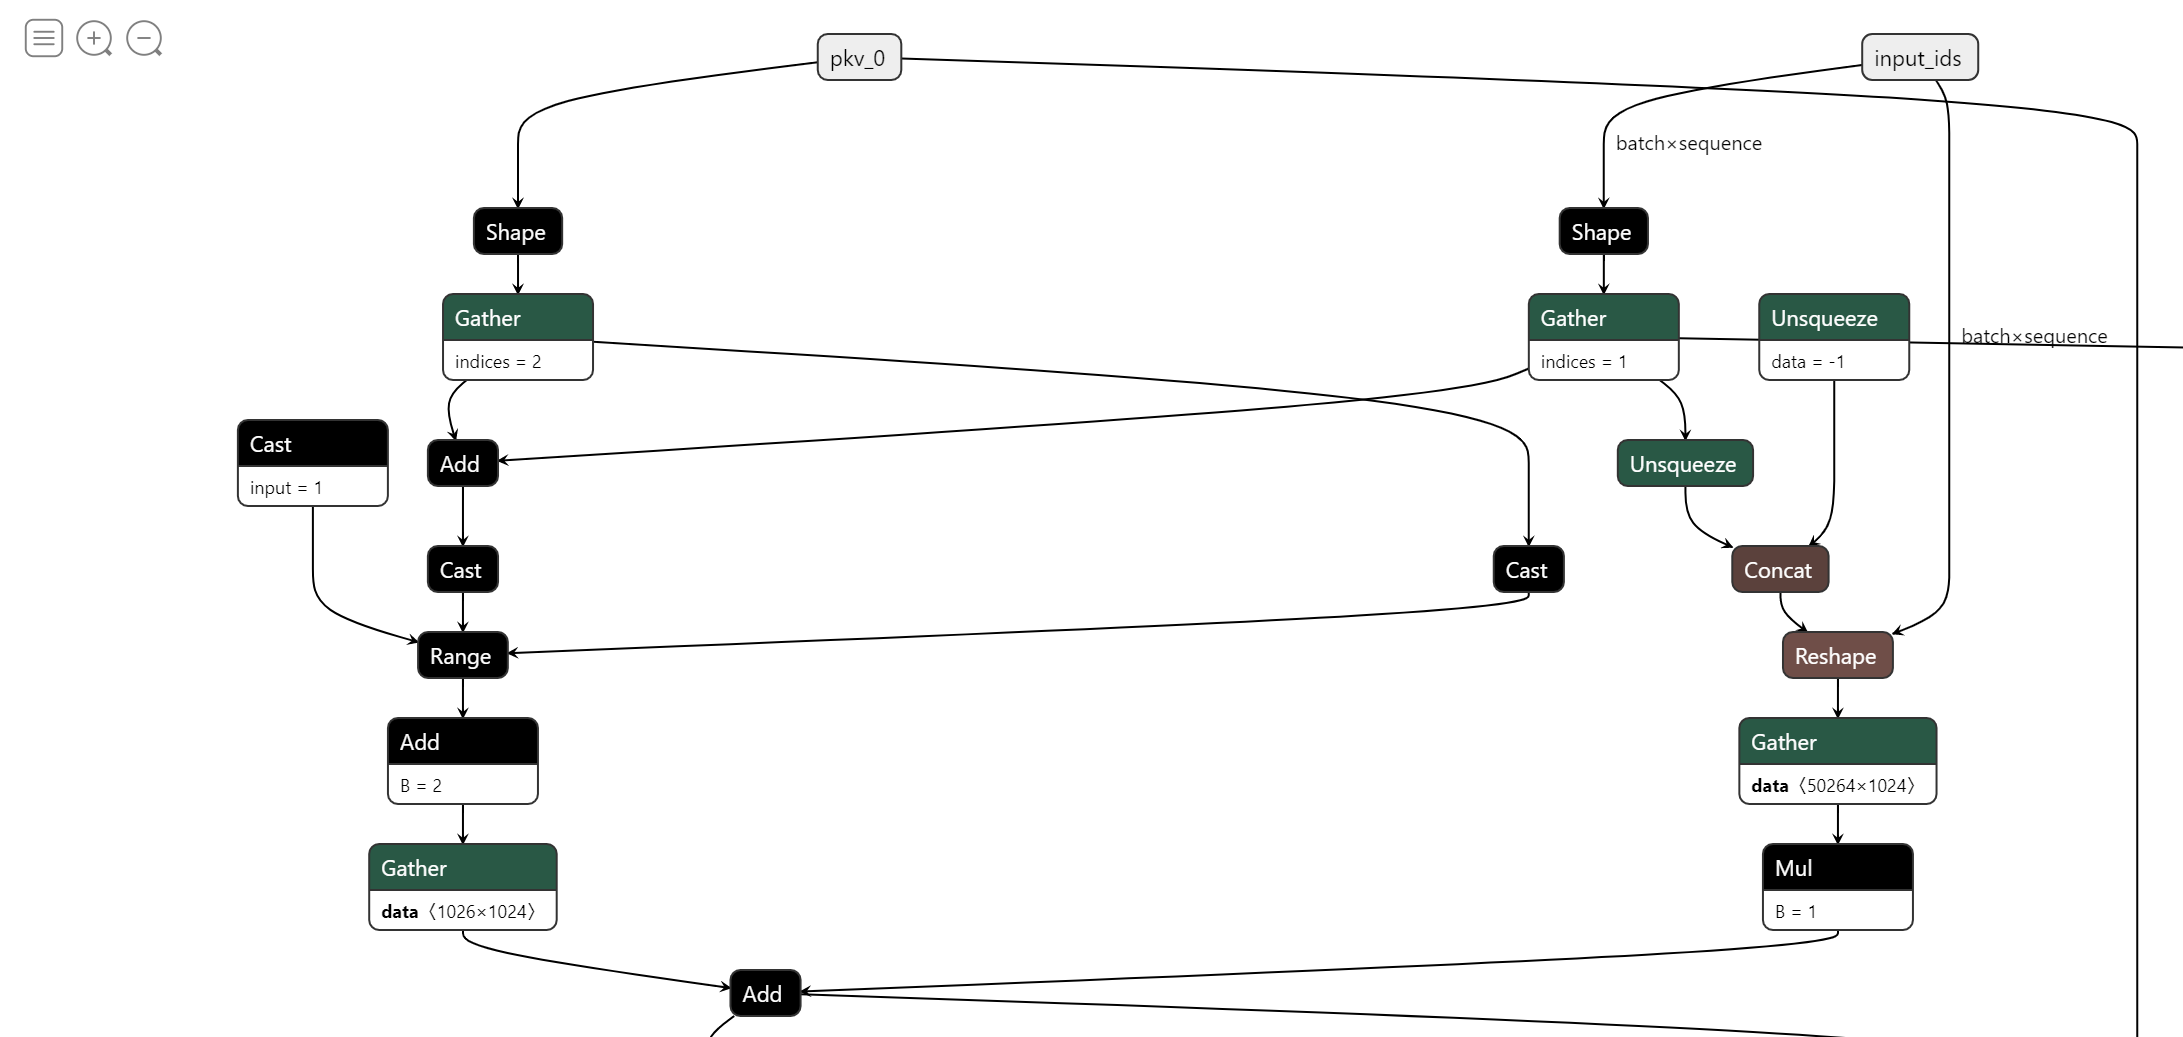